In [30]:
# coding: utf-8
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
import pandas as pd
import seaborn as sns
from scipy import stats
from itertools import *
from sklearn.preprocessing import StandardScaler
from sklearn.feature_selection import VarianceThreshold
from sklearn.feature_selection import SelectKBest,f_classif,chi2,SelectPercentile
from sklearn.linear_model import Lasso,lasso_path,LassoCV
from sklearn.preprocessing import label_binarize
from sklearn.multiclass import OneVsRestClassifier
from sklearn.model_selection import train_test_split
from sklearn import svm
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn import tree
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_curve,auc,roc_auc_score
from scipy.stats import sem
from pandas import Series,DataFrame
# import joblib
from sklearn.externals import joblib
from sklearn.model_selection import StratifiedKFold
from scipy import interp
from sklearn.feature_selection import SelectFromModel
import pickle
import os
from sklearn.model_selection import GridSearchCV
from sklearn.svm import SVC
import warnings
warnings.filterwarnings('ignore')
%matplotlib inline
sns.set_style('white')
plt.rcParams['figure.dpi'] = 500#当保存图片时调成300，更清晰

In [31]:
import sklearn
sklearn.__version__

'0.20.3'

In [2]:
path = ''

out_path = os.path.join('result20200924_SVM') #修改日期即可，会自动创建文件夹
if not os.path.isdir(out_path):
    os.makedirs(out_path)
    
# out_path1_train = 'result20200919\\radiomics\\train'
# out_path1_test = 'result20200919\\radiomics\\test'
# out_path2_train = 'result20200919\\radiomics_cli\\train'
# out_path2_test = 'result20200919\\radiomics_cli\\test'

out_path1_train = os.path.join(out_path, 'radiomics','train')
if not os.path.isdir(out_path1_train):
    os.makedirs(out_path1_train)
    
out_path1_test = os.path.join(out_path, 'radiomics','test')
if not os.path.isdir(out_path1_test):
    os.makedirs(out_path1_test)

out_path2_train = os.path.join(out_path, 'radiomics_cli','train')
if not os.path.isdir(out_path2_train):
    os.makedirs(out_path2_train)
    
out_path2_test = os.path.join(out_path, 'radiomics_cli','test')
if not os.path.isdir(out_path2_test):
    os.makedirs(out_path2_test)

        
new_df = pd.read_csv(os.path.join(path,'original_data.csv'), encoding='gbk',index_col=0)
data_uni = new_df .drop_duplicates(subset=['custom_custom_patient_id'], keep='first', inplace=False)

In [3]:
# ML
# clf = MLPClassifier(hidden_layer_sizes=(16, ))
# clf = LogisticRegression(penalty='l2',class_weight='balanced',solver='newton-cg')
# clf = LogisticRegression(penalty='l2',class_weight='balanced',solver='newton-cg')
# clf = LogisticRegression(penalty='l1',class_weight='balanced')
# clf = LogisticRegression()
# clf1 = LogisticRegression()
# clf2 = LogisticRegression()
# svm
# tuned_parameters = [{'kernel': ['rbf','poly','sigmoid'], 'gamma': [1e-3, 1e-4],
#                      'C': [ 1, 10, 100, 1000]},
#                     {'kernel': ['linear'], 'C': [ 1, 10, 100, 1000]}]
# clf = svm.SVC(kernel='linear',probability=True)
# clf = svm.SVC(kernel='poly',probability=True)
clf = svm.SVC(kernel='linear',probability=True,class_weight='balanced',C= 1, gamma= 0.001)
# clf = svm.SVC(kernel='poly',probability=True,class_weight='balanced', gamma= 0.001)

### 创建输出路径，读取csv文件，dataframe表格输入？

In [4]:
def read_file(path,out_path):
    
    data_path = os.path.join(out_path, 'data')#连接两个或更多的路径名组件
    if not os.path.isdir(data_path):#用于判断某一对象(需提供绝对路径)是否为目录
        os.makedirs(data_path)#用于递归创建目录。如果子目录创建失败或者已经存在，会抛出一个 OSError 的异常
    
    df = pd.read_csv(path, encoding='gbk',index_col=0)#index_col:指定哪一列数据作为行索引
    data_uni = df.dropna(axis=1, how='any')#能够找到DataFrame类型数据的空值（缺失值），将空值所在的行/列删除。
    #1或'columns'，表示按列删除，any’，表示该行/列只要有一个以上的空值，就删除该行/列；

    print (len(data_uni))

    new_df = pd.DataFrame(new_df.values,
                        index=new_df.custom_custom_patient_id.map(str) + '-' + new_df.custom_custom_voi_type.map(str),
                        columns=cols)#一个Datarame表示一个表格，它的每一列都可以有不同的类型值（数字，字符串，布尔等等）

    data_uni = new_df.drop_duplicates(subset=['custom_custom_patient_id'], keep='first', inplace=False)#返回一个移除了重复行的DataFrame
#     print (len(data_uni)) 
    
#     new_df.to_csv(os.path.join(data_path, 'original_data.csv'))
#     data_uni.to_csv(os.path.join(data_path, 'patient_data.csv'))
    

    return new_df,data_uni

### 创建输出目录，提取custom以外的列为new_x，建立new_y, group看不懂？

In [5]:
def train_test(new_df,data_uni,y_name,threshold,random_state,out_path):

    data_path = os.path.join(out_path, 'data')
    if not os.path.isdir(data_path):
        os.makedirs(data_path)
        
    origin_features = new_df.columns #读列名称
    feature_extracting = [feature for feature in origin_features if 'custom' not in feature]###提取custom以外的列名
    new_x = new_df.loc[:,feature_extracting] #df.loc[行标签,列标签]
    
#     new_x = new_df.iloc[:, 1:]
    new_y = new_df.loc[:, y_name]
    new_y = pd.DataFrame(new_y)
    
    grouped = new_y.groupby(y_name)#划分为若干个分组DataFrame
    uniquekeys=[]
    data = []
    for k,g in grouped:# k,g在y_name里有？
        groups=list(g)
        uniquekeys=k
        print (uniquekeys)
    y0 = grouped.get_group(0)#通过调用get_group()函数可以返回一个按照分组得到的DataFrame对象
    y1 = grouped.get_group(1)
    X0 = DataFrame(new_x,index=y0.index)
    X1 = DataFrame(new_x,index=y1.index)
    
    X_train0, X_test0, y_train0, y_test0 = train_test_split(X0, y0, test_size=0.1639344,random_state=random_state)#训练集和test比例
    X_train1, X_test1, y_train1, y_test1 = train_test_split(X1, y1, test_size=0.28169,random_state=random_state)
    
    print ('lenth patient-train-0 = {}'.format(len(X_train0)))
    print ('lenth patient-train-1 = {}'.format(len(X_train1)))
    print ('lenth patient-test-0 = {}'.format(len(X_test0)))
    print ('lenth patient-test-1 = {}'.format(len(X_test1)))
    
    X_train = pd.concat([X_train0,X_train1],axis=0,join='inner')#数据拼接
    X_test = pd.concat([X_test0,X_test1],axis=0,join='inner')
    y_train = pd.concat([y_train0,y_train1],axis=0,join='inner')
    y_test = pd.concat([y_test0,y_test1],axis=0,join='inner')
    
    ss = StandardScaler().fit(X_train)#计算训练数据的均值和方差
    X_train_std = ss.transform(X_train)#把训练数据转换成标准的正态分布，用lasso时要用
    X_train_std = DataFrame(X_train_std,index=X_train.index,columns=X_train.columns)
    
    X_test_std = ss.transform(X_test)#为什么不用StandardScaler().fit？
    X_test_std = DataFrame(X_test_std,index=X_test.index,columns=X_test.columns)
    
    X_train.to_csv(os.path.join(data_path, 'X_train.csv'))
    X_test.to_csv(os.path.join(data_path, 'X_test.csv'))
    y_train.to_csv(os.path.join(data_path, 'y_train.csv'))
    y_test.to_csv(os.path.join(data_path, 'y_test.csv'))
    X_train_std.to_csv(os.path.join(data_path, 'X_train_std.csv'))
    X_test_std.to_csv(os.path.join(data_path, 'X_test_std.csv'))
    
    y_train = np.array(y_train, dtype = int)
    y_test = np.array(y_test, dtype = int)
    
    return X_train_std,y_train,X_test_std,y_test

### 特定行取整?

In [6]:
from imblearn.over_sampling import SMOTE,ADASYN
from imblearn.under_sampling import RandomUnderSampler

def smote_data(features, y ,random,data_path):
    
    sm = SMOTE(random_state= 42 ,sampling_strategy={0:120,1:120})
#     sm = ADASYN(random_state=random)

    
    print (len(features))
    print ('lenth of y = ',len(y))
    
    features_plus, histology_plus = sm.fit_sample(features, y)
    print ("dataset has {} data points with {} variables each.".format(*features_plus.shape))
    print ('lenth of plus y = ',len(histology_plus))

    features_plus=pd.DataFrame(features_plus,columns=features.columns)
    #特定行取整（比如性别0，1 smote后需要取整）
    
    y_plus=pd.DataFrame(histology_plus,columns=["Label"])
        
    data_plus = pd.concat([y_plus,features_plus],axis = 1,join = 'inner')
    data_plus.to_csv(os.path.join(data_path, 'data_plus.csv'))

    return features_plus,y_plus


In [7]:
# help(SMOTE)

In [8]:
def train_test_radcloud(new_df,data_uni,y_name,train_test_name,out_path):
    
    data_path = os.path.join(out_path, 'data')
    if not os.path.isdir(data_path):
        os.makedirs(data_path)
        
    x_all = data_uni.iloc[:, 19:]#根据行列数提取内容
    y_all = pd.DataFrame(data=pd.Categorical(data_uni.loc[:, y_name]).codes,
                         columns=["labels"],
                         index=data_uni.index)
    
    grouped = new_df.groupby(train_test_name)
    uniquekeys=[]
    data = []
    for k,g in grouped:
        groups=list(g)
        uniquekeys=k
        print (uniquekeys)
    all_test = grouped.get_group('test')
    all_train = grouped.get_group('train')
    
    X_test = DataFrame(x_all,index=all_test.index)
    X_train = DataFrame(x_all,index=all_train.index)
    y_test = DataFrame(y_all,index=all_test.index)
    y_train = DataFrame(y_all,index=all_train.index)
    
    
    ss = StandardScaler().fit(X_train)
    X_train_std = ss.transform(X_train)
    X_train_std = DataFrame(X_train_std,index=X_train.index,columns=X_train.columns)
    
    X_test_std = ss.transform(X_test)
    X_test_std = DataFrame(X_test_std,index=X_test.index,columns=X_test.columns)
    
    X_train.to_csv(os.path.join(data_path, 'X_train.csv'))
    X_test.to_csv(os.path.join(data_path, 'X_test.csv'))
    y_train.to_csv(os.path.join(data_path, 'y_train.csv'))
    y_test.to_csv(os.path.join(data_path, 'y_test.csv'))
    X_train_std.to_csv(os.path.join(data_path, 'X_train_std.csv'))
    X_test_std.to_csv(os.path.join(data_path, 'X_test_std.csv'))
    
    y_train = np.array(y_train, dtype = int)
    y_test = np.array(y_test, dtype = int)
    
    return X_train_std,y_train,X_test_std,y_test

### 同一个患者多个VOI，同一个患者的多个要绑定到训练集或者测试集

In [9]:
def train_test_patient(new_df,data_uni,y_name,threshold,random_state,out_path):

    data_path = os.path.join(out_path, 'data')
    if not os.path.isdir(data_path):
        os.makedirs(data_path)
 
    uni_x = data_uni.iloc[:, 19:]
    uni_y = data_uni.loc[:, y_name]
    uni_y = pd.DataFrame(uni_y)

    grouped = uni_y.groupby(y_name)
    for k, g in grouped:
        groups = list(g)
        uniquekeys = k
        print (uniquekeys)
    y0 = grouped.get_group(0)
    y1 = grouped.get_group(1)
    X0 = DataFrame(uni_x, index=y0.index)
    X1 = DataFrame(uni_x, index=y1.index)

    X_train0, X_test0, y_train0, y_test0 = train_test_split(X0, y0, test_size=threshold, random_state=random_state)
    X_train1, X_test1, y_train1, y_test1 = train_test_split(X1, y1, test_size=threshold, random_state=random_state)
    
    print ('lenth patient-train-0 = {}'.format(len(X_train0)))
    print ('lenth patient-train-1 = {}'.format(len(X_train1)))
    print ('lenth patient-test-0 = {}'.format(len(X_test0)))
    print ('lenth patient-test-1 = {}'.format(len(X_test1)))

    X_train = pd.concat([X_train0, X_train1], axis=0, join='inner')
    X_test = pd.concat([X_test0, X_test1], axis=0, join='inner')
    y_train = pd.concat([y_train0, y_train1], axis=0, join='inner')
    y_test = pd.concat([y_test0, y_test1], axis=0, join='inner')

    print ('lenth patient x_test = {}'.format(len(X_test)))
    print ('lenth patient x_train = {}'.format(len(X_train)))

    train_patient_list = [idx.split('_')[0] for idx in X_train.index]
    train_voi_type_list = [idx.split('_')[1] for idx in X_train.index]

    test_patient_list = [idx.split('_')[0] for idx in X_test.index]
    test_voi_type_list = [idx.split('_')[1] for idx in X_test.index]

    train_idx_list = X_train.index

    for idx in new_df.index:
        new_pid = idx.split('_')[0]
        new_voi_type = idx.split('_')[1]

        new_x = new_df.ix[idx, 19:]
        new_y = new_df.ix[idx, y_name]
        new_y = pd.DataFrame(new_y, index=[idx], columns=[y_name])

        if new_pid in train_patient_list:
            train_idx = train_patient_list.index(new_pid)
            train_voi_type = train_voi_type_list[train_idx]
            if new_voi_type != train_voi_type:
                X_train = X_train.append(new_x)
                y_train = y_train.append(new_y)
            else:
                continue
        else:
            test_idx = test_patient_list.index(new_pid)
            test_voi_type = test_voi_type_list[test_idx]
            if new_voi_type != test_voi_type:
                X_test = X_test.append(new_x)
                y_test = y_test.append(new_y)

    print ('lenth voi x_test = {}'.format(len(y_test)))
    print ('lenth voi x_train = {}'.format(len(X_train)))
    
    ss = StandardScaler().fit(X_train)
    X_train_std = ss.transform(X_train)
    X_train_std = DataFrame(X_train_std,index=X_train.index,columns=X_train.columns)
    
    X_test_std = ss.transform(X_test)
    X_test_std = DataFrame(X_test_std,index=X_test.index,columns=X_test.columns)
    
    X_train.to_csv(os.path.join(data_path, 'X_train.csv'))
    X_test.to_csv(os.path.join(data_path, 'X_test.csv'))
    y_train.to_csv(os.path.join(data_path, 'y_train.csv'))
    y_test.to_csv(os.path.join(data_path, 'y_test.csv'))
    X_train_std.to_csv(os.path.join(data_path, 'X_train_std.csv'))
    X_test_std.to_csv(os.path.join(data_path, 'X_test_std.csv'))
    
    y_train = np.array(y_train, dtype = int)
    y_test = np.array(y_test, dtype = int)
    print (X_train_std.shape)
    print (y_train.shape)
    
    
    return X_train_std,y_train,X_test_std,y_test

In [10]:
def select_KBest(X,y,out_path):
    
    fs_path = os.path.join(out_path, 'fs')
    if not os.path.isdir(fs_path):
        os.makedirs(fs_path)
    
    sel = SelectKBest(f_classif,k = 'all').fit(X,np.ravel(y))
    scores = sel.scores_
    pvalue = sel.pvalues_
    features = X.columns
    result = sel.get_support()
    sort_features = []
    for index, item in enumerate(features):
        if result[index]:
            sort_features.append(item)
    # 将特征按分数 从大到小 排序  
    named_scores = zip(features, scores, pvalue)    
    sorted_named_scores = sorted(named_scores,key = lambda z:z[1],reverse = True)
    sorted_pvalue = [each[2] for each in sorted_named_scores if each[2]<0.05]  
    sorted_scores = [each[1] for each in sorted_named_scores]  
    sorted_names = [each[0] for each in sorted_named_scores]
    print (len(sorted_pvalue))
    num = len(sorted_pvalue)
    sel_features = sorted_names[0:num]
    X = X[sel_features]
    y =y
    print("features reduced from {0} to {1}".format(len(features),len(sel_features)))
    
    num = len(sorted_pvalue)
    fe = sorted_names[0:num]
    stats_result = pd.DataFrame({'score':sorted_scores[0:num],
                             'p':sorted_pvalue[0:num]},
                            index = list(fe))
    print (stats_result)
    named_scores = list(named_scores)
    named_scores = pd.DataFrame(named_scores,columns = ['feature','p_value','score'])
    named_scores.to_csv(os.path.join(fs_path, 'all_P_score.csv'))
    stats_result.to_csv(os.path.join(fs_path, 'sk_P_score.csv'))
    sel2_result = X[fe]
    sel2_result.to_csv(os.path.join(fs_path,'selectKbest.csv'))
    
    return X,y,sel_features

In [11]:
def select_KBest_cli(X,y,out_path):
    
    fs_path = os.path.join(out_path, 'fs')
    if not os.path.isdir(fs_path):
        os.makedirs(fs_path)
    
    sel = SelectKBest(chi2,k = 'all').fit(X,np.ravel(y))
    scores = sel.scores_
    pvalue = sel.pvalues_
    features = X.columns
    result = sel.get_support()
    sort_features = []
    for index, item in enumerate(features):
        if result[index]:
            sort_features.append(item)
    # 将特征按分数 从大到小 排序  
    named_scores = zip(features, scores, pvalue)    
    sorted_named_scores = sorted(named_scores,key = lambda z:z[1],reverse = True)
    sorted_pvalue = [each[2] for each in sorted_named_scores if each[2]<0.05]  
    sorted_scores = [each[1] for each in sorted_named_scores]  
    sorted_names = [each[0] for each in sorted_named_scores]
    print (len(sorted_pvalue))
    num = len(sorted_pvalue)
    sel_features = sorted_names[0:num]
    X = X[sel_features]
    y =y
    print("features reduced from {0} to {1}".format(len(features),len(sel_features)))
    
    num = len(sorted_pvalue)
    fe = sorted_names[0:num]
    stats_result = pd.DataFrame({'score':sorted_scores[0:num],
                             'p':sorted_pvalue[0:num]},
                            index = list(fe))
    print (stats_result)
    named_scores = pd.DataFrame(named_scores,columns = ['feature','p_value','score'])
    named_scores.to_csv(os.path.join(fs_path, 'all_P_score.csv'))
    stats_result.to_csv(os.path.join(fs_path, 'sk_P_score.csv'))
    sel2_result = X[fe]
    sel2_result.to_csv(os.path.join(fs_path,'selectKbest.csv'))
    
    return X,y,sel_features

In [12]:
def lasso_filter(X,y,cv,out_path):
    
    fs_path = os.path.join(out_path, 'fs')
    if not os.path.isdir(fs_path):
        os.makedirs(fs_path)
    
    model = LassoCV(cv=cv,max_iter=2000).fit(X,y)
    selected =  -np.log10(model.alpha_)
    m_log_alphas = -np.log10(model.alphas_)
    features = X.columns
    coef = pd.Series(model.coef_, index = features)
    sel_coef = coef[coef!=0]  
    print (sel_coef)
    sel_features = sel_coef.index
    X = X[sel_features]
    print("features reduced from {0} to {1}".format(len(features),len(sel_features)))
    
    plt.figure()
    plt.plot(m_log_alphas, model.mse_path_, ':')
    plt.plot(m_log_alphas, model.mse_path_.mean(axis=-1), 'k',label='Average across the folds', linewidth=2)
    plt.axvline(-np.log10(model.alpha_), linestyle='--', color='k',label='alpha: CV estimate')
    plt.legend()
    plt.xlabel('-log(alpha)')
    plt.ylabel('Mean square error')
    plt.savefig(os.path.join(fs_path,"lasso1.png"))
    plt.show()

    eps = 1e-2 # the smaller it is the longer is the path
    alphas_lasso, coefs_lasso, _ = lasso_path(X, np.ravel(y), eps, fit_intercept=False)
    plt.figure()
    ax = plt.gca()
    colors = cycle(['b', 'r', 'g', 'c', 'k'])
    neg_log_alphas_lasso = -np.log10(alphas_lasso)
    for coef_l, c in zip(coefs_lasso,colors):
        l1 = plt.plot(neg_log_alphas_lasso, coef_l, c=c)
    plt.axvline(-np.log10(model.alpha_), linestyle='--', color='k',label='alpha: CV estimate')
    plt.xlabel('-Log(alpha)')
    plt.ylabel('coefficients')
    plt.title('Lasso Path')
    plt.axis('tight')
    plt.savefig(os.path.join(fs_path,"lasso2.png"))
    plt.show()
    
    selected_coef = coef[coef!=0]  
    lasso_feature = selected_coef.index
    lasso_result = X[lasso_feature]
    lasso_result.to_csv(os.path.join(fs_path,'lasso_sel.csv')) #需要可导出
    y = pd.DataFrame(y,index = X.index,columns = ['y'])

    y_Xsel = pd.concat([y,lasso_result],axis=1,join='inner',ignore_index= False)
    y_Xsel.to_csv(os.path.join(fs_path,'y_Xsel.csv'))
    
    lasso_result.to_csv(os.path.join(fs_path,'x_train_sel.csv')) #需要可导出
    
    mp_coef = pd.concat([selected_coef.sort_values()])
    print (len(mp_coef))
    #print mp_coef
    mp_coef.to_csv(os.path.join(fs_path,'lasso-xishu.csv'))

    return X,y,sel_features,mp_coef

In [13]:
def auc_report(y_test,y_pred,y_pred_prob,clf_path):
    
    fpr,tpr,thresholds = roc_curve(y_test,y_pred_prob, pos_label=1)
    auc_result = roc_auc_score(y_test, y_pred_prob)
    #figure
    plt.plot([0, 1], [0, 1], 'k--', lw=2)
    plt.plot(fpr, tpr, label='AUC is %0.3f'%auc_result)
    plt.rcParams['font.size'] = 8
    plt.legend(loc="lower right",fontsize=8)
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.0])
    
    #plt.title('ROC curve for T2 classifier')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    #plt.legend(fontsize=8)
    plt.savefig(os.path.join(clf_path,"test_auc.png"))
    plt.show()
    #cut-off point
    i = np.arange(len(tpr))
    roc = pd.DataFrame({'tf' : pd.Series(tpr-(1-fpr), index=i), 'threshold' : pd.Series(thresholds, index=i)})
    roc_t = roc.ix[(roc.tf-0).abs().argsort()[:1]]
    threshold_value = roc_t['threshold'].values
    print (threshold_value)
    print ('auc = ',auc_result)
    
    ##########以threshold_value值为阈值，大于的为1，＜的为0，生成预测值y_pred_threshold,并返回，用来生成混淆矩阵

    npatients = len(y_pred)
    y_pred_threshold = y_pred_prob
    for num in range (0,npatients):
        if y_pred_prob[num] > threshold_value:
            y_pred_threshold[num] = 1
        else:
            y_pred_threshold[num] = 0
    y_pred_threshold = DataFrame(y_pred_threshold)
    return y_test,y_pred,auc_result

In [14]:
###混淆矩阵计算
def analysis_report(y_true,y_pred,y_pred_probas,clf_path):
#     labels = list(set(y_true))
    y_true = np.array(y_true, dtype = int)
    conf_mat = confusion_matrix(y_true, y_pred)
    print (conf_mat)
    result0 = classification_report(y_true, y_pred)
    
    path_save = os.path.join(clf_path, 'matric_report.txt')
    with open(path_save, 'w') as f:  #
        f.write(str(conf_mat))
    with open(path_save, 'a') as f:  #
        f.write(result0) 
    
    TN = conf_mat[1,1]
    TP = conf_mat[0,0]
    FN = conf_mat[0,1]
    FP = conf_mat[1,0]
    Accuracy = ((TP + TN)*1.0)/(TN + TP + FN + FP)
    Precision = (TP*1.0)/(TP + FP)
    Sensitivity = (TP*1.0)/(TP + FN)
    Specificity = (TN*1.0)/(TN + FP)
    print ('Accuracy = ',Accuracy)
    print ('Precision = ',Precision)
    print ('Sensitivity = ',Sensitivity)
    print ('Specificity = ',Specificity)
        
    y_pred = np.array(y_pred_probas)
    ####%95CI
    n_bootstraps = 1000
    rng_seed = 42  # control reproducibility
    bootstrapped_scores = []
    rng = np.random.RandomState(rng_seed)
    for i in range(n_bootstraps):
        # bootstrap by sampling with replacement on the prediction indices
        indices = rng.randint(0, len(y_pred_probas) - 1, len(y_pred_probas))
        if len(np.unique(y_true[indices])) < 2:
            # We need at least one positive and one negative sample for ROC AUC
            # to be defined: reject the sample
            continue
        score = roc_auc_score(y_true[indices], y_pred[indices])
        bootstrapped_scores.append(score)
#         print("Bootstrap #{} ROC area: {:0.3f}".format(i + 1, score))
    sorted_scores = np.array(bootstrapped_scores)

    sorted_scores.sort()

    # Computing the lower and upper bound of the 90% confidence interval
    # You can change the bounds percentiles to 0.025 and 0.975 to get
    # a 95% confidence interval instead.
    confidence_lower = sorted_scores[int(0.05 * len(sorted_scores))]
    confidence_upper = sorted_scores[int(0.95 * len(sorted_scores))]
    print ("The Data Confidence interval for the score: [{:0.3f} - {:0.3}]".format(confidence_lower, confidence_upper))
    
    return Accuracy,Sensitivity,Specificity,confidence_lower, confidence_upper

In [15]:
def model_training(X,y,clf,cv,clf_path):
        
    y = np.array(y, dtype = int)
    
    X_index = X.index
    X_index = DataFrame(X_index,columns=['X_index'])
    X = np.array(X) 
    yprob = DataFrame()

    cv = StratifiedKFold(n_splits=cv)
    tprs = []
    aucs = []
    mean_fpr = np.linspace(0, 1, 100)
    
    i = 1
    auc_best = 0.5
    y_pred_threshold = []
    for train, test in cv.split(X, y):
        probas_ = clf.fit(X[train], y[train]).predict_proba(X[test])
        pred_ = clf.fit(X[train], y[train]).predict(X[test])
        #print probas_
        #print pred_
    # Compute ROC curve and area the curve
        fpr, tpr, thresholds = roc_curve(y[test], probas_[:, 1])
        tprs.append(interp(mean_fpr, fpr, tpr))
        tprs[-1][0] = 0.0
        roc_auc = auc(fpr, tpr)
        aucs.append(roc_auc)
        plt.plot(fpr, tpr, lw=1, alpha=0.3,label='ROC fold %d (AUC = %0.3f)' % (i, roc_auc))
        plt.rcParams['font.size'] = 8
        #plt.legend(fontsize=8)
        i += 1
        if roc_auc > auc_best:
            auc_best = roc_auc
            print ('auc_best = ',auc_best)
            probas_ = clf.fit(X[train], y[train]).predict_proba(X[train])
            pred_ = clf.fit(X[train], y[train]).predict(X[train])
            model = pickle.dumps(clf)
            y_label_train = y[train]
            y_pred_probas = probas_[:,1]
            y_pred_threshold = pred_
            y_true = DataFrame(y_label_train,columns = ['y_true'])
            y_pred_probas = DataFrame(y_pred_probas,columns = ['y_proba0'])
            y_pred_threshold = DataFrame(y_pred_threshold,columns = ['y_pred'])
            y_true_pred = pd.concat([y_true,y_pred_threshold,y_pred_probas],axis=1,join='inner',ignore_index = False )
            y_true_pred.to_csv(os.path.join(clf_path,' yTrain_true_pred.csv'))
            
            probas_test = clf.fit(X[train], y[train]).predict_proba(X[test])
            pred_test = clf.fit(X[train], y[train]).predict(X[test])
            y_label_test = y[test]
            y_pred_probas_test = probas_test[:,1]
            y_pred_threshold_test = pred_test
            y_true_test = DataFrame(y_label_test,columns = ['y_true'])
            y_pred_probas_test = DataFrame(y_pred_probas_test,columns = ['y_proba0'])
            y_pred_threshold_test = DataFrame(y_pred_threshold_test,columns = ['y_pred'])
            y_true_pred_test = pd.concat([y_true_test,y_pred_threshold_test,y_pred_probas_test],axis=1,join='inner',ignore_index = False )
            y_true_pred_test.to_csv(os.path.join(clf_path,' yVal_true_pred.csv'))
        
        #matrix = confusion_matrix(y[test],pred_)
        '''
        yprobabi = DataFrame(probas_,index = test, columns = ['y_proba0','y_proba1'])
        y_true = DataFrame(y[test],index = test,columns = ['y_true'])
        y_pred = DataFrame(pred_,index = test,columns = ['y_pred'])
        yprobabi = pd.concat([y_true,y_pred,yprobabi],axis=1,join='inner',ignore_index = True)
        yprob = yprob.append(yprobabi)
        y_proba = yprob.sort_index()
        '''
    
    plt.plot([0, 1], [0, 1], linestyle='--', lw=2, color='r',label='Luck', alpha=.8)
    
    i = np.arange(len(tpr))
    roc = pd.DataFrame({'tf' : pd.Series(tpr-(1-fpr), index=i), 'threshold' : pd.Series(thresholds, index=i)})
    roc_t = roc.ix[(roc.tf-0).abs().argsort()[:1]]
    threshold_value = roc_t['threshold'].values
    print ('threshold_value = ')
    print (threshold_value)
    
    mean_tpr = np.mean(tprs, axis=0)
    mean_tpr[-1] = 1.0
    mean_auc = auc(mean_fpr, mean_tpr)
    print (mean_auc)
    
    std_auc = np.std(aucs)
    plt.plot(mean_fpr, mean_tpr, color='b',label=r'Mean ROC (AUC = %0.3f $\pm$ %0.3f)' % (mean_auc, std_auc),lw=2, alpha=.8)
    
    std_tpr = np.std(tprs, axis=0)
    tprs_upper = np.minimum(mean_tpr + std_tpr, 1)
    tprs_lower = np.maximum(mean_tpr - std_tpr, 0)
    plt.fill_between(mean_fpr, tprs_lower, tprs_upper, color='grey', alpha=.2,label=r'$\pm$ 1 std. dev.')

    plt.xlim([-0.05, 1.05])
    plt.ylim([-0.05, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver operating characteristic example')
    plt.legend(loc="lower right",fontsize=8)
    plt.savefig(os.path.join(clf_path,"train_auc.png"))
    plt.show()
        
    ############以threshold_value值为阈值，大于的为1，＜的为0，生成预测值y_pred_threshold,并返回，用来生成混淆矩阵
    
    return model,mean_auc,y_label_train,y_pred_threshold,y_pred_probas

In [16]:
def model_testing(model,X_test,y_test,clf_path):

    X_test.to_csv(os.path.join(clf_path,'x_test_sel.csv'))
    
    X_index = X_test.index

    clf = pickle.loads(model)
    y_pred = clf.predict(X_test)
    y_pred_prob = clf.predict_proba(X_test)[:,1]

    y_pred_use = y_pred_prob
    y_pred_prob = DataFrame(y_pred_prob,index = X_index, columns = ['y_proba0'])
    y_test = DataFrame(y_test,index = X_index,columns = ['y_true'])
    y_pred = DataFrame(y_pred,index = X_index,columns = ['y_pred'])
    
    yTest_true_pred = pd.concat([y_test,y_pred,y_pred_prob],axis=1,join='inner',ignore_index = False)
    yTest_true_pred.to_csv(os.path.join(clf_path,'yTest_true_pred.csv'))

    return y_pred,y_pred_prob,y_pred_use

In [17]:
def rad_score(feature,coef,path_in):
    feature_name = feature.columns
    coefficient = coef[feature_name]
    
    radscore = np.dot(feature , coefficient)
    radscore = pd.DataFrame(radscore,index = feature.index)
    radscore.columns = ['rad_score']

    radscore.to_csv(os.path.join(path_in,'radscore.csv'))
    return radscore

In [18]:
threshold = 0.2
y_name = 'custom_custom_class'
clinical = new_df.iloc[:, 1:11]

In [19]:
# result1=[]
# result3=[]

# random_smote = 42

# lasso_cv = [5,10]
# ml_cv = [5,10]

# i = 5
# for random in range(51,80):
# # for random in range(86,87):
#     try:
#         try:
#             X_train_Rad,y_train,X_test_Rad,y_test = train_test(new_df,data_uni,y_name,threshold,random,out_path)
# #             X_train_Rad.to_csv(os.path.join(out_path2_test,'X_train_Rad_{}.csv'.format(random)))
# #             y_train.to_csv(os.path.join(out_path2_test,'X_train_Rad_{}.csv'.format(random)))
# #             X_train_Rad.to_csv(os.path.join(out_path2_test,'X_train_Rad_{ }.csv'.format(random)))
# #             X_train_Rad.to_csv(os.path.join(out_path2_test,'X_train_Rad_{ }.csv'.format(random)))
            
#             X_train_plus,y_train_plus, = smote_data(X_train_Rad, y_train ,random,out_path)
#             y_train_plus = np.array(y_train_plus, dtype = int)

#             print ('len X_train_rad:',len(X_train_plus))
#             print ('random = ',random)
#             X_kbest,y_kbest,features_name_kbest = select_KBest(X_train_plus, y_train_plus,out_path1_train)
#             X_lasso, y_lasso, features_name_lasso,coef = lasso_filter(X_kbest,y_kbest,5,out_path1_train) 
#             radsTrain = rad_score(X_lasso,coef,out_path1_train)

#             y_lasso = DataFrame(y_lasso,index = X_lasso.index)#

#             X_train_all_sel = pd.concat([X_lasso,clinical],axis = 1,join = 'inner')
#             Train_ima_score_cli = pd.concat([y_lasso,X_lasso,radsTrain,clinical],axis = 1,join = 'inner')
#             Train_ima_score_cli.to_csv(os.path.join(out_path2_train,'X_sel_train.csv'))

#             y_test = DataFrame(y_test,index = X_test_Rad.index)#

#             X_test_rad_sel = DataFrame(X_test_Rad, index=X_test_Rad.index, columns=X_lasso.columns)
#             radsTest = rad_score(X_test_rad_sel,coef,out_path1_test)

#             X_test_all_sel = pd.concat([X_test_rad_sel,clinical],axis = 1,join = 'inner')
#             Test_ima_score_cli = pd.concat([y_test,X_test_rad_sel,radsTest,clinical],axis = 1,join = 'inner')
#             Test_ima_score_cli.to_csv(os.path.join(out_path2_test,'X_sel_test.csv'))
#             #Radiomics#

#             model,mean_auc,y_label_train,y_pred_threshold,y_pred_probas = model_training(X_lasso, np.ravel(y_lasso), clf, i,out_path1_train)
#             tra_acc,tra_sen,tra_spe,tra_CI_L,tra_CI_H = analysis_report(y_label_train,y_pred_threshold,y_pred_probas,out_path1_train)
#             y_pred_test, y_proba_test,y_pred_use = model_testing(model, X_test_rad_sel, np.ravel(y_test),out_path1_test)#
#             y_test,y_pred_threshold,auc_result = auc_report(y_test, y_pred_test, y_pred_use,out_path1_test)#
#             test_acc,test_sen,test_spe,test_CI_L,test_CI_H = analysis_report(y_test,y_pred_test,y_pred_threshold,out_path1_test) #

#             result = np.array([random,len(features_name_kbest),len(features_name_lasso),mean_auc,tra_acc,tra_sen,tra_spe,tra_CI_L,tra_CI_H,
#                                 auc_result,test_acc,test_sen,test_spe,test_CI_L,test_CI_H])
#             result = pd.DataFrame(result)
#             result_t = result.transpose()
#             result_t = pd.DataFrame(result_t)
#             result1 = result1.append(result_t) 
#             result1 = pd.DataFrame(result1)
#             print (result1)

#             print ('######################')

#             #Radiomics_clinical

#         #             model1,mean_auc1,y_label_train1,y_pred_threshold1,y_pred_probas1 = model_training_grid_search(X_train_all_sel, np.ravel(y_lasso), clf1, i,out_path2_train)
#         #             tra_acc1,tra_sen1,tra_spe1,tra_CI_L1,tra_CI_H1 = analysis_report(y_label_train1,y_pred_threshold1,y_pred_probas1,out_path2_train)
#         #             y_pred_test1, y_proba_test1,y_pred_use1 = model_testing(model1, X_test_all_sel, np.ravel(y_test),out_path2_test)
#         #             y_test1,y_pred_threshold1,auc_result1 = auc_report(y_test, y_pred_test1, y_pred_use1,out_path2_test)
#         #             test_acc1,test_sen1,test_spe1,test_CI_L1,test_CI_H1 = analysis_report(y_test1,y_pred_test1,y_pred_threshold1,out_path2_test) 

#         #             result2 = np.array([random,len(features_name_kbest),len(features_name_lasso),mean_auc1,tra_acc1,tra_sen1,tra_spe1,tra_CI_L1,tra_CI_H1,
#         #                                 auc_result1,test_acc1,test_sen1,test_spe1,test_CI_L1,test_CI_H1])
#         #             result2 = pd.DataFrame(result2)
#         #             result_t2 = result2.transpose()
#         #             result_t2 = pd.DataFrame(result_t2)
#         #             result3 = result3.append(result_t2) 
#         #             result3 = pd.DataFrame(result3)
#         #             print result3
# #             print '%%%%%%%%%%%%%%%%%'

#         except ValueError:
#             print ('select 0 num feature')
#             pass
#     except IndexError:
#         print ('select 0 mun feature')
#         pass

### 总结大循环里的参数成表格

In [20]:
# result1.columns = ['random','sel_fea','features_cli',
#                    'tra_auc','tra_acc','tra_sen','tra_spe','tra_CI_L','tra_CI_H',
#                    'test_auc','test_acc','test_sen','test_spe','test_CI_L','test_CI_H']
# result1.to_csv(os.path.join(out_path1_test,'random_RESULT.csv'))  

# # result3.columns = ['random','sel_fea','features_cli',
# #                    'tra_auc','tra_acc','tra_sen','tra_spe','tra_CI_L','tra_CI_H',
# #                    'test_auc','test_acc','test_sen','test_spe','test_CI_L','test_CI_H']
# # result3.to_csv(os.path.join(out_path2_test,'RAD_CLI_10_sk-ls-lr_RESULT.csv')) 

# # df = pd.read_csv(path,index_col=0)#index_col:指定哪一列数据作为行索引




In [21]:
# help(pd.read_csv)

0
1
lenth patient-train-0 = 102
lenth patient-train-1 = 51
lenth patient-test-0 = 20
lenth patient-test-1 = 20
153
lenth of y =  153
dataset has 240 data points with 1409 variables each.
lenth of plus y =  240
len X_train_rad: 240
random =  70
303
features reduced from 1409 to 303
                                                           p     score
original_firstorder_Kurtosis                        0.006711  7.479329
original_glszm_LowGrayLevelZoneEmphasis             0.009197  6.896483
logarithm_glszm_LowGrayLevelZoneEmphasis            0.009197  6.896483
original_glszm_HighGrayLevelZoneEmphasis            0.009197  6.896483
logarithm_glszm_HighGrayLevelZoneEmphasis           0.009197  6.896483
original_gldm_LargeDependenceLowGrayLevelEmphasis   0.009459  6.844745
logarithm_gldm_LargeDependenceLowGrayLevelEmphasis  0.009459  6.844745
original_gldm_DependenceVariance                    0.013273  6.225199
logarithm_gldm_DependenceVariance                   0.013273  6.225199
original

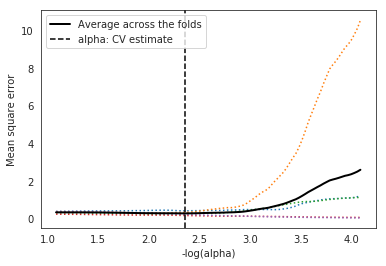

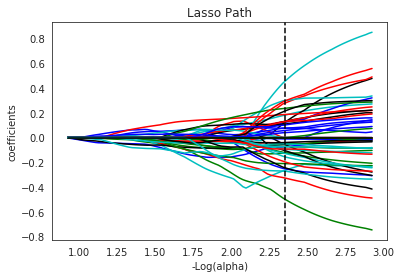

70
random =  70


In [22]:
random = 70 
i=5
X_train_Rad,y_train,X_test_Rad,y_test = train_test(new_df,data_uni,y_name,threshold,random,out_path)
X_train_plus,y_train_plus, = smote_data(X_train_Rad, y_train ,random,out_path)
y_train_plus = np.array(y_train_plus, dtype = int)

print ('len X_train_rad:',len(X_train_plus))
print ('random = ',random)
X_kbest,y_kbest,features_name_kbest = select_KBest(X_train_plus, y_train_plus,out_path1_train)
X_lasso, y_lasso, features_name_lasso,coef = lasso_filter(X_kbest,y_kbest,5,out_path1_train) 
radsTrain = rad_score(X_lasso,coef,out_path1_train)

y_lasso = DataFrame(y_lasso,index = X_lasso.index)#

X_train_all_sel = pd.concat([X_lasso,clinical],axis = 1,join = 'inner')
Train_ima_score_cli = pd.concat([y_lasso,X_lasso,radsTrain,clinical],axis = 1,join = 'inner')
Train_ima_score_cli.to_csv(os.path.join(out_path2_train,'X_sel_train.csv'))

y_test = DataFrame(y_test,index = X_test_Rad.index)#

X_test_rad_sel = DataFrame(X_test_Rad, index=X_test_Rad.index, columns=X_lasso.columns)
radsTest = rad_score(X_test_rad_sel,coef,out_path1_test)

X_test_all_sel = pd.concat([X_test_rad_sel,clinical],axis = 1,join = 'inner')
Test_ima_score_cli = pd.concat([y_test,X_test_rad_sel,radsTest,clinical],axis = 1,join = 'inner')
Test_ima_score_cli.to_csv(os.path.join(out_path2_test,'X_sel_test.csv'))
#Radiomics#

print ('random = ', random)
# print ('lenth of sel_feature =',len(features_name))
# print ('cv_ml = ',i =5)
#Radiomics#

In [23]:
# # svm
# # clf = svm.SVC(kernel='linear',probability=True)
# # clf = svm.SVC(kernel='poly',probability=True)
# # clf1 = svm.SVC(kernel='linear',probability=True,class_weight='balanced')
# tuned_parameters = [{'kernel': ['rbf','poly','sigmoid'], 'gamma': [1e-3, 1e-4],
#                      'C': [ 1, 10, 100, 1000]},
#                     {'kernel': ['linear'], 'C': [ 1, 10, 100, 1000]}]
# svm = SVC(probability = True)
# clf = GridSearchCV(svm, tuned_parameters,cv=5, scoring='roc_auc')
# clf.fit(X_lasso, np.ravel(y_lasso))
 
# clf.cv_results_
 
# print(-clf.best_score_)
# print(clf.best_params_)


In [24]:
# help(svm)

五折交叉验证每一折的时候超参一样，但是每一折都会构建一个细微差别的模型。因为比如MLP有很多参数是自动的。

In [25]:
print (clf)

SVC(C=1, cache_size=200, class_weight='balanced', coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma=0.001, kernel='linear',
  max_iter=-1, probability=True, random_state=None, shrinking=True,
  tol=0.001, verbose=False)


In [26]:
# clf.best_estimator_

In [27]:
# clf.cv_results_

auc_best =  0.8524305555555555
auc_best =  0.890625
auc_best =  0.9097222222222222
threshold_value = 
[0.51729664]
0.8555555555555555


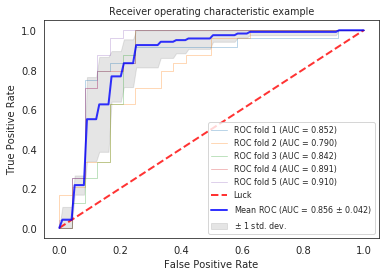

[[81 15]
 [ 4 92]]
Accuracy =  0.9010416666666666
Precision =  0.9529411764705882
Sensitivity =  0.84375
Specificity =  0.9583333333333334
The Data Confidence interval for the score: [0.884 - 0.959]


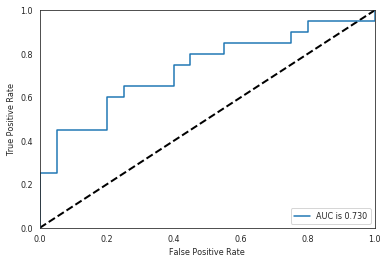

[0.39845812]
auc =  0.73
[[17  3]
 [11  9]]
Accuracy =  0.65
Precision =  0.6071428571428571
Sensitivity =  0.85
Specificity =  0.45
The Data Confidence interval for the score: [0.540 - 0.771]


In [28]:
i=5
model,mean_auc,y_label_train,y_pred_threshold,y_pred_probas = model_training(X_lasso, np.ravel(y_lasso), clf, i,out_path1_train)#重新划分五折看验证集，
# acc,sen,spe,CI_L,CI_H = analysis_report(X[train],y_pred_threshold,y_pred_probas,out_path1_train)
tra_acc,tra_sen,tra_spe,tra_CI_L,tra_CI_H = analysis_report(y_label_train,y_pred_threshold,y_pred_probas,out_path1_train)
y_pred_test, y_proba_test,y_pred_use = model_testing(model, X_test_rad_sel, np.ravel(y_test),out_path1_test)
y_test,y_pred_threshold,auc_result = auc_report(y_test, y_pred_test, y_pred_use,out_path1_test)
test_acc,test_sen,test_spe,test_CI_L,test_CI_H = analysis_report(y_test,y_pred_test,y_pred_threshold,out_path1_test) 

In [29]:
# help(model_training)